In [1]:
import numpy as np
import gymnasium as gym
from gymnasium import spaces
import time
import torch
import numpy as np
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

In [2]:
class MultiAgentFeatureExtractor(BaseFeaturesExtractor):
    def __init__(self, observation_space: spaces.Box, n_agents: int, features_dim: int):
        super(MultiAgentFeatureExtractor, self).__init__(observation_space, features_dim)
        self.n_agents = n_agents

        input_dim_per_agent = observation_space.shape[0]  
        self.fc1 = nn.Linear(input_dim_per_agent, 256)  
        self.fc2 = nn.Linear(256, features_dim)

    def forward(self, observations):
        x = F.relu(self.fc1(observations))
        #print(f"Shape after fc1: {x.shape}")  
        x = self.fc2(x)
        #print(f"Shape after fc2: {x.shape}")  
        return x

In [3]:
class CustomPPO(PPO):
    def __init__(self, *args, **kwargs):
        super(CustomPPO, self).__init__(*args, **kwargs)

        self.optimizer = self.policy.optimizer

    def train(self):
        for rollout_data in self.rollout_buffer.get(self.batch_size):

            # Retrieve data from the buffer
            observations = rollout_data.observations
            actions = rollout_data.actions
            old_log_prob = rollout_data.old_log_prob 
            advantages = rollout_data.advantages
            returns = rollout_data.returns

            # Forward pass to compute policy and value outputs
            values, log_probs, entropy = self.policy.forward(observations)

            #print("Observations shape:", observations.shape)
            #print("Actions shape:", actions.shape)
            #print("Advantages shape:", advantages.shape)
            #print("Returns shape:", returns.shape)

            # Compute the policy loss
            ratio = torch.exp(log_probs - old_log_prob)
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1 - self.clip_range(1.0), 1 + self.clip_range(1.0)) * advantages
            policy_loss = -torch.min(surr1, surr2).mean()

            # Compute the value loss
            value_loss = F.mse_loss(returns.unsqueeze(-1).expand_as(values), values)


            # Compute the entropy loss
            entropy_loss = -entropy.mean()

            #print("Values shape:", values.shape)
            #print("Returns shape:", returns.unsqueeze(-1).shape)

            # Use the custom loss function
            custom_loss = self.custom_loss(policy_loss, value_loss, entropy_loss)

            #print("Custom loss:", custom_loss.item())

            # Backpropagate and update
            self.optimizer.zero_grad()
            custom_loss.backward()
            self.optimizer.step()
    
    def custom_loss(self, policy_loss, value_loss, entropy_loss):
         policy_loss = policy_loss.mean()  
         value_loss = value_loss.mean()    
         entropy_loss = entropy_loss.mean() 
         return policy_loss + 0.5 * value_loss - 0.01 * entropy_loss


In [4]:
class JointActionSpaceWrapper(gym.Env):
    def __init__(self, env):
        super(JointActionSpaceWrapper, self).__init__()
        self.env = env
        self.n_agents = env.n_agents

        # Define the joint action space
        action_spaces = []
        for space in env.action_space:
            if isinstance(space, gym.spaces.Discrete):
                action_spaces.append([space.n])
            elif isinstance(space, gym.spaces.MultiDiscrete):
                action_spaces.append(space.nvec)
        self.action_space = gym.spaces.MultiDiscrete(np.concatenate(action_spaces, axis=0))

        # Define the joint observation space
        obs_shape = (self.n_agents * env.observation_space[0].shape[0],)
        self.observation_space = gym.spaces.Box(
            low=-np.inf, 
            high=np.inf, 
            shape=obs_shape, 
            dtype=np.float32
        )

    def reset(self, seed=None, **kwargs):
        obss, info = self.env.reset(seed=seed, **kwargs)
        obss = [np.array([o]) if np.isscalar(o) else o for o in obss]
        return np.concatenate(obss), info
    
    def step(self, actions):
        # Split actions for each agent
        split_actions = np.split(actions, self.n_agents)

        # Pass actions to the environment
        obss, rewards, done, truncated, info = self.env.step(split_actions)

        # Concatenate observations from all agents
        obss = [np.array([o]) if np.isscalar(o) else o for o in obss]
        joint_obs = np.concatenate(obss)

        # Aggregate rewards for cooperation
        joint_reward = float(sum(rewards) / self.n_agents)

    
        if isinstance(done, bool):
            joint_done = done or truncated
        else:
            joint_done = all(done) or all(truncated)

        return joint_obs, joint_reward, joint_done, truncated, info


Using cpu device


/home/lary/anaconda3/envs/rl_env/lib/python3.8/site-packages/gymnasium/utils/passive_env_checker.py:275: UserWarning: WARN: The reward returned by `step()` must be a float, int, np.integer or np.floating, actual type: <class 'list'>
  logger.warn(


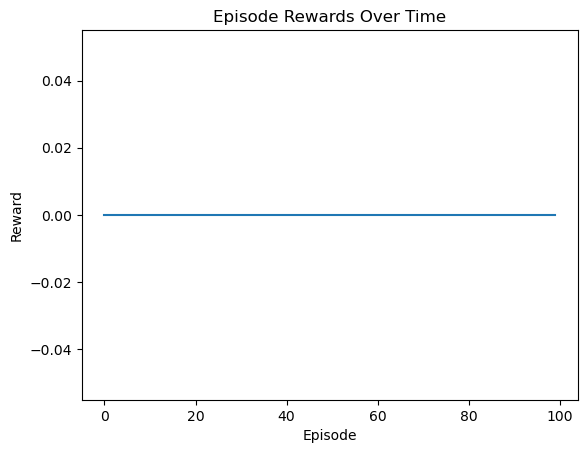

In [5]:
def train_agent(model, env, total_timesteps=50000, max_episode_steps=1000):
    episode_rewards = []
    episode_lengths = []

    obs = env.reset()
    total_episodes = 0
    timestep = 0

    while timestep < total_timesteps:
        # Reset episode-specific variables
        done = False
        episode_reward = 0
        episode_length = 0

        # Run a single episode
        while not done and episode_length < max_episode_steps:
            # Select action and step environment
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, _ = env.step(action)
            episode_reward += reward
            episode_length += 1
            timestep += 1

            # Add experience to the buffer and train if it's full
            if model.rollout_buffer.full:
                model.train()

        # Record episode data
        episode_rewards.append(episode_reward)
        episode_lengths.append(episode_length)
        total_episodes += 1
        #print(f"Episode {total_episodes} - Reward: {episode_reward}, Length: {episode_length}")

        # Reset environment at the end of each episode
        obs = env.reset()

        # Save model periodically
        if total_episodes % 10 == 0:
            model.save("ppo_multi_agent_coordinated")

    return episode_rewards, episode_lengths



# Run training
# Environment layout
layout = """
g......
...x...
..x.x..
.x...x.
..x.x..
...x...
......g
"""

# Create and wrap the warehouse environment
env = gym.make("rware:rware-tiny-2ag-v2", layout=layout)
wrapped_env = JointActionSpaceWrapper(env)
vec_env = DummyVecEnv([lambda: wrapped_env])

policy_kwargs = dict(
    features_extractor_class=MultiAgentFeatureExtractor,
    features_extractor_kwargs=dict(n_agents=2, features_dim=142),
    net_arch=dict(pi=[128, 64], vf=[128, 64])
)

# Initialize custom PPO model with joint observations and actions
model = CustomPPO('MlpPolicy', vec_env, policy_kwargs=policy_kwargs, verbose=1)

rewards, lengths = train_agent(model, vec_env)

#Plot rewards
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.title("Episode Rewards Over Time")
plt.show()

In [6]:
model = PPO.load("ppo_multi_agent_coordinated")
obs = vec_env.reset()
done = False

env.render()

for step in range(500):
    # Predict actions using the trained model
    actions, _states = model.predict(obs)
    actions = np.squeeze(actions)  # Ensure actions are in the correct shape

    # Step through the environment​
    obs, rewards, done, truncated, info = wrapped_env.step(actions)

    # Render the environment
    env.render()
    time.sleep(0.1)

    # Reset the environment if done
    if done or truncated:
        obs = wrapped_env.reset()

env.close

/home/lary/anaconda3/envs/rl_env/lib/python3.8/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


<bound method Wrapper.close of <OrderEnforcing<PassiveEnvChecker<Warehouse<rware-tiny-2ag-v2>>>>>